In [2]:
import yfinance as yf
import pandas as pd

# 1. 원하는 티커 리스트 (예: 미국 대표 기술주 10개)
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX', 'INTC', 'AMD']

# 2. 2023년부터 현재까지 일봉 데이터 다운로드
ohlcv_data = yf.download(tickers, start="2023-01-01", interval="1d", group_by='ticker', auto_adjust=False, threads=True)

# 3. 종가만 추출하여 (N, 10) 형태의 데이터프레임 생성
price_df = pd.DataFrame({ticker: ohlcv_data[ticker]['Close'] for ticker in tickers})

# 출력 예시
price_df

[*********************100%***********************]  10 of 10 completed


,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,NFLX,INTC,AMD
Date,,,,,,,,,,
2023-01-03,125.070000,239.580002,89.120003,85.820000,124.739998,14.315000,108.099998,294.950012,26.730000,64.019997
2023-01-04,126.360001,229.100006,88.080002,85.139999,127.370003,14.749000,113.639999,309.410004,27.680000,64.660004
2023-01-05,125.019997,222.309998,86.199997,83.120003,126.940002,14.265000,110.339996,309.700012,27.559999,62.330002
2023-01-06,129.619995,224.929993,87.339996,86.080002,130.020004,14.859000,113.059998,315.549988,28.730000,63.959999
2023-01-09,130.149994,227.119995,88.019997,87.360001,129.470001,15.628000,119.769997,315.170013,29.309999,67.239998
...,...,...,...,...,...,...,...,...,...,...
2025-03-28,217.899994,378.799988,154.330002,192.720001,576.739990,109.669998,263.549988,933.849976,22.709999,103.220001
2025-03-31,222.130005,375.390015,154.639999,190.259995,576.359985,108.379997,259.160004,932.530029,22.709999,102.739998
2025-04-01,223.190002,382.190002,157.070007,192.169998,586.000000,110.150002,268.459991,928.380005,22.049999,102.779999


In [3]:
import numpy as np
import pandas as pd


class Metric:
    """
    Strategy Performance Metric Calculator
    """

    def __init__(self, portfolio_value: pd.Series):
        self.portfolio_value = portfolio_value

    def evaluate(self):
        """
        Final Result
        """
        return {
            "sharpe_ratio": self._calculate_sharpe_ratio(),
            "mdd": self._calculate_maxiumum_drawdown(),
            "win_rate": self._calculate_win_rate(),
            "pnl_rate": self._calculate_pnl_rate(),
            "total_loss": self._calculate_total_loss(),
            "total_profit": self._calculate_total_profit(),
            "final_margin": self._calculate_final_margin(),
            "cumulative_return": self._calculate_cumulative_return(),
        }

    def _calculate_cumulative_return(self):
        """
        calculating cumulative return
        """
        pv = self.portfolio_value
        return round(pv.iloc[-1] / pv.iloc[0] - 1, 4)

    def _calculate_final_margin(self):
        """
        calculating final margin
        """
        pv = self.portfolio_value
        return round(pv.iloc[-1], 4)

    def _calculate_sharpe_ratio(self):
        """
        calculating sharpe ratio
        """
        pv = self.portfolio_value

        # 일별 수익률 계산
        ret = pv.pct_change().dropna()

        # 연율화 샤프지수 계산
        mean_excess_return = np.mean(ret)
        std_return = np.std(ret)

        sharpe_ratio = (mean_excess_return / (std_return + 1e-10)) * np.sqrt(252)
        return round(sharpe_ratio, 4)

    def _calculate_maxiumum_drawdown(self):
        """
        calculating mdd
        """
        pv = self.portfolio_value

        rolling_max = np.maximum.accumulate(pv)
        # Drawdown
        drawdowns = (rolling_max - pv) / rolling_max
        # Maximum Drawdown
        mdd = np.max(drawdowns)
        return round(mdd, 4)

    def _calculate_win_rate(self):
        """
        calculating win rate
        """
        pv = self.portfolio_value

        diff = pv.diff()

        rate = diff[diff > 0].shape[0] / diff.shape[0]
        return round(rate, 4)

    def _calculate_total_profit(self):
        """
        calculating total profit
        """
        pv = self.portfolio_value

        diff = pv.diff()

        total_profit = sum(diff[diff > 0])
        return round(total_profit, 4)

    def _calculate_total_loss(self):
        """
        calculating total loss
        """
        pv = self.portfolio_value

        diff = pv.diff()

        total_loss = sum(diff[diff < 0])
        return round(total_loss, 4)

    def _calculate_pnl_rate(self):
        """
        calculating pnl rate
        """
        if self._calculate_total_loss() == 0:
            return np.inf

        rate = self._calculate_total_profit() / (self._calculate_total_loss() + 1e-10)
        return round(abs(rate), 4)


## 백테스팅

- 백테스팅에는 2가지 타입이 있음
- 이벤트 드리븐 백테스팅 (Event-Driven Backtesting)
- 벡터라이즈 백테스팅 (Vectorized Backtesting)

In [4]:
def vectorized_backtest(price_df: pd.DataFrame, weight_df: pd.DataFrame):
  """
  벡터 벡테스팅
  """
  market_return = price_df.pct_change().shift(-1)

  returns = (weight_df * market_return).sum(axis=1)
  cum_returns = (1 + returns.cumsum())

  initial_margin = 100
  portfolio_value = initial_margin * cum_returns
  return portfolio_value

def vectorized_backtest_wight_metric(price_df: pd.DataFrame, weight_df: pd.DataFrame):
  """
  벡터 벡테스팅
  """
  pv = vectorized_backtest(price_df, weight_df)
  metric = Metric(pv)
  return metric.evaluate()

## Equal Weight Long Only Portfolio

- 동일 가중 포트폴리오 백테스팅
- 승률 53 %
- 손익비 1.33
- MDD 11 %
- 샤프 2.04

In [7]:
num_tickers = price_df.shape[1]

weight_df = pd.DataFrame(np.ones_like(price_df) / num_tickers, index=price_df.index, columns=price_df.columns)
weight_df

,AAPL,MSFT,GOOGL,AMZN,META,NVDA,TSLA,NFLX,INTC,AMD
Date,,,,,,,,,,
2023-01-03,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2023-01-04,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2023-01-05,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2023-01-06,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2023-01-09,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
...,...,...,...,...,...,...,...,...,...,...
2025-03-28,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2025-03-31,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2025-04-01,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


<Axes: xlabel='Date'>

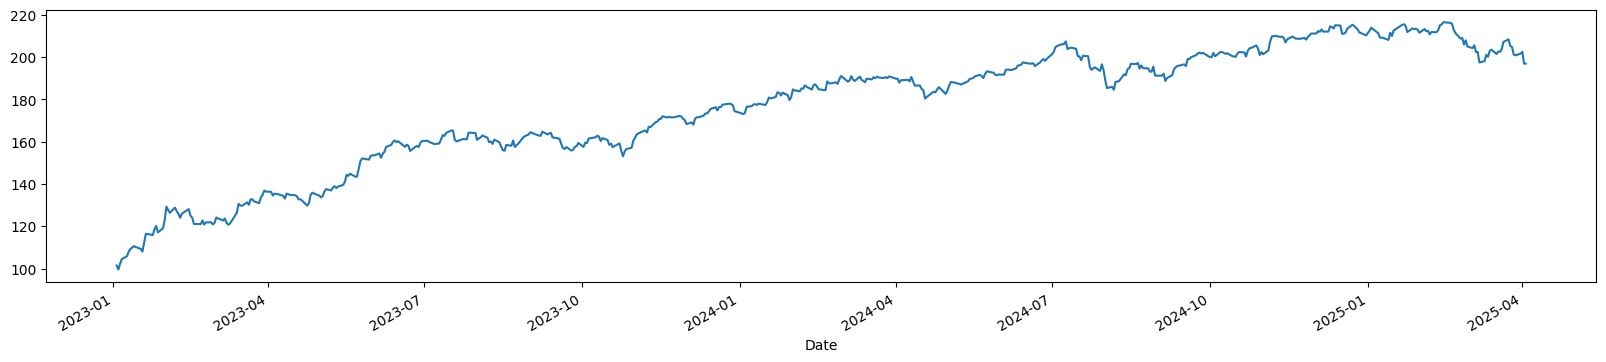

In [8]:
pv = vectorized_backtest(price_df, weight_df)
pv.plot(figsize=(20, 4))

In [9]:
result = vectorized_backtest_wight_metric(price_df, weight_df)
result

{'sharpe_ratio': np.float64(1.9467),
 'mdd': np.float64(0.1105),
 'win_rate': 0.5345,
 'pnl_rate': 1.3131,
 'total_loss': -304.8675,
 'total_profit': 400.3201,
 'final_margin': np.float64(196.8945),
 'cumulative_return': np.float64(0.941)}